In [1]:
# imports
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

/Users/HariRaval/miniconda3/envs/thesis/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# loss function
def loss(t, A, lambda_val, model, loss_term_weights):
        
    # create the trial solution
    u_t = lambda t: A + (1 - torch.exp(-t)) * model(t)

    # compute u_0 for normalizing loss (t = 0)
    u_0 = u_t(torch.tensor([[0]], dtype=torch.float32))
    
    # define f 
    f = lambda t, u: -lambda_val * u 

    # compute u(t)
    outputs = u_t(t)
        
    # compute du / dt
    u_t_x = torch.autograd.grad(outputs, t, grad_outputs=torch.ones_like(outputs),
                        create_graph=True)[0]
    # compute d^2u / dt^2
    u_tt_x = torch.autograd.grad(u_t_x, t, grad_outputs=torch.ones_like(u_t_x),
                        create_graph=True)[0]
    # compute d^3u / dt^3
    u_ttt_x = torch.autograd.grad(u_tt_x, t, grad_outputs=torch.ones_like(u_tt_x),
                        create_graph=True)[0]
    
    # define f' (derivative of f)
    f_t = lambda t, u_t_x: -lambda_val * u_t_x # f_t --> diff eq residual
    
    # define f'' (derivative of f')
    f_tt = lambda t, u_tt_x: -lambda_val * u_tt_x
    
    # original loss function
    L_D = torch.mean((u_t_x - f(t, outputs)) ** 2)
    
    # first derivative loss term
    L_DD = torch.mean((u_tt_x - f_t(t, u_t_x)) ** 2) # Note: why is f_t and f_tt dependent on t and outputs?
    
    # second derivative loss term
    L_DDD = torch.mean((u_ttt_x - f_tt(t, u_tt_x)) ** 2) 
    
    return ((loss_term_weights[0] * L_D)  + (loss_term_weights[1] * L_DD) + (loss_term_weights[2] * L_DDD)) * 1 / u_0 ** 2


In [3]:
# function to build, train, and run the model
def run_model(iterations, min_x, max_x, A, lambda_val, loss_term_weights):

    # build the neural net model
    model = nn.Sequential(nn.Linear(1, 64), nn.Tanh(), nn.Linear(64, 64), nn.Tanh(), nn.Linear(64,1)) 
    # set-up the optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    
    # create a random number generator for loss computation
    rng = np.random.default_rng()
    losses = []
    
    # run the training loop
    for i in range(iterations):
        # every batch, randomly sample from min and max range
        x = torch.arange(min_x, max_x, 0.001, requires_grad=True)
        x = x[rng.integers(low=0, high=len(x), size=500)]
        x = x.reshape(-1, 1)

        # forward: compute loss
        l = loss(x, A, lambda_val, model, loss_term_weights)
        losses.append(l.item())
        
        # backward: backpropagation
        l.backward()
        
        # update weights and reset the gradients
        optimizer.step() 
        optimizer.zero_grad() 
        
    return losses, model

In [5]:
# function to plot the neural network vs exact solution
def plot_solution(min_x, max_x, A, lambda_val, trained_model, axis):
    
    u_t = lambda t: A + (1 - torch.exp(-t)) * trained_model(t)

    # plot the solution accuracies
    xx = np.linspace(min_x, max_x, 200)[:, None]

    with torch.no_grad():
        yy = u_t(torch.Tensor(xx)).numpy()

    yt = A * np.exp(-lambda_val * xx)

    axis.plot(xx, yt, label='Actual')
    axis.plot(xx, yy, '--', label='Neural Network')
    axis.set_title("u(t) vs t for actual and approximation")
    axis.set_xlabel('$t$')
    axis.set_ylabel('$u(t)$')
    axis.legend(loc='best')

In [6]:
# function to plot the loss of the network solution
def plot_loss(iterations, train_losses, axis):
    axis.plot(range(iterations), train_losses, label='log of loss')
    axis.set_yscale("log") # base = 10 
    axis.set_title("Log of Losses vs iterations")
    axis.set_xlabel('Iteration')
    axis.set_ylabel('Loss')
    axis.legend(loc='best')

In [7]:
# wrapper function to plot the solution and the loss 
def plot_loss_and_solution(min_x, max_x, A, lambda_val, iterations, trained_model, train_losses):
    fig, axs = plt.subplots(1, 2,  tight_layout=True, figsize=(16, 8))
    plot_loss(iterations=iterations, train_losses=train_losses, axis=axs[0])
    plot_solution(min_x=min_x, max_x=max_x, A=A, lambda_val=lambda_val, trained_model=trained_model, axis=axs[1])
    plt.show()

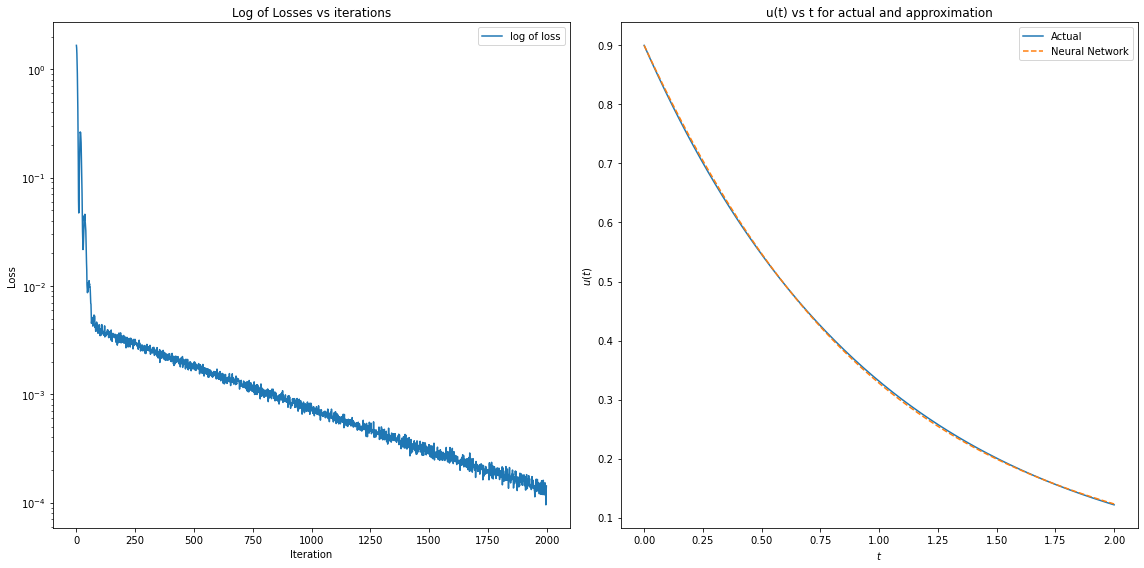

In [8]:
min_x, max_x = 0, 2
A, lambda_val = 0.9, 1
iterations = 2000
loss_term_weights = [1, 0, 0]

# run the trained model with a set number of iterations and for min and max x range
train_losses, trained_model = run_model(iterations=iterations, min_x=min_x, max_x=max_x, A=A, lambda_val=lambda_val, loss_term_weights=loss_term_weights)
plot_loss_and_solution(min_x=min_x, max_x=max_x, A=A, lambda_val=lambda_val, iterations=iterations, trained_model=trained_model, train_losses=train_losses)

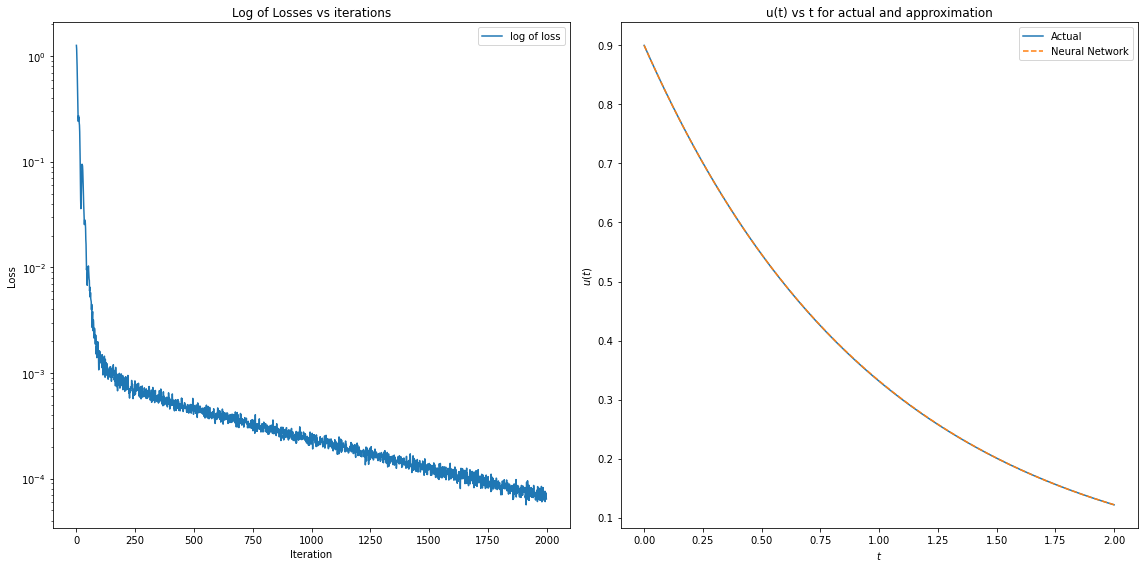

In [9]:
min_x, max_x = 0, 2
A, lambda_val = 0.9, 1
iterations = 2000
loss_term_weights = [1, 1, 0]

# run the trained model with a set number of iterations and for min and max x range
train_losses, trained_model = run_model(iterations=iterations, min_x=min_x, max_x=max_x, A=A, lambda_val=lambda_val, loss_term_weights=loss_term_weights)
plot_loss_and_solution(min_x=min_x, max_x=max_x, A=A, lambda_val=lambda_val, iterations=iterations, trained_model=trained_model, train_losses=train_losses)

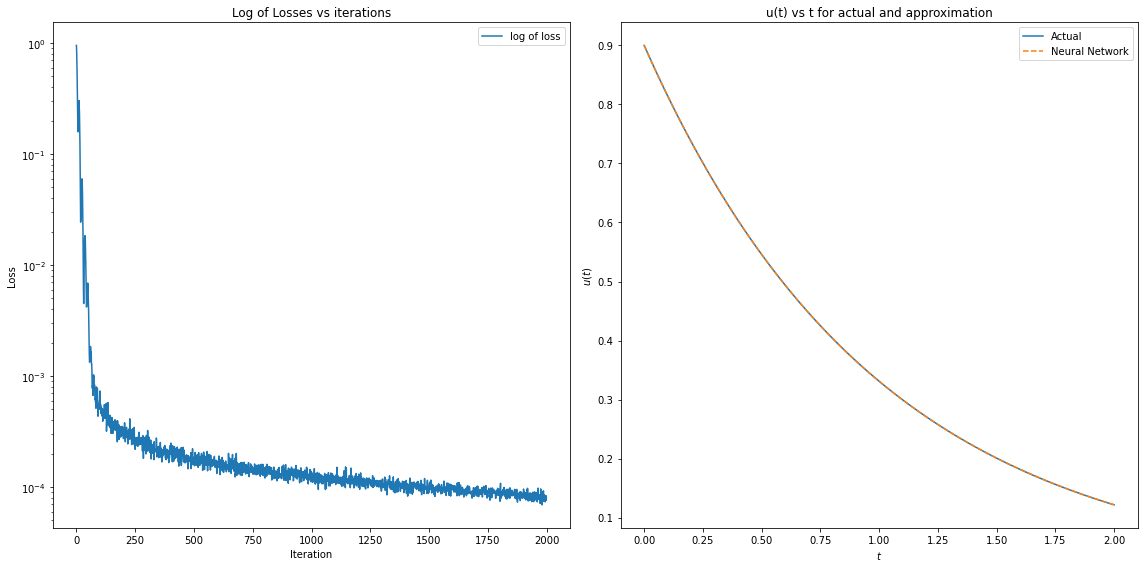

In [11]:
min_x, max_x = 0, 2
A, lambda_val = 0.9, 1
iterations = 2000
loss_term_weights = [1, 1, 1]

# run the trained model with a set number of iterations and for min and max x range
train_losses, trained_model = run_model(iterations=iterations, min_x=min_x, max_x=max_x, A=A, lambda_val=lambda_val, loss_term_weights=loss_term_weights)
plot_loss_and_solution(min_x=min_x, max_x=max_x, A=A, lambda_val=lambda_val, iterations=iterations, trained_model=trained_model, train_losses=train_losses)

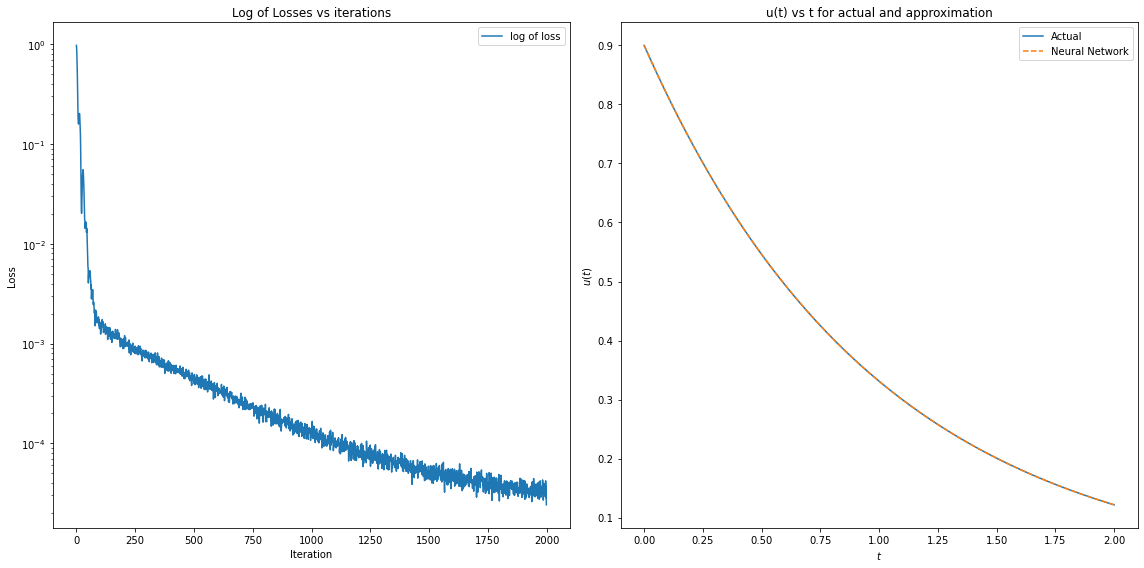

In [12]:
min_x, max_x = 0, 2
A, lambda_val = 0.9, 1
iterations = 2000
loss_term_weights = [1, 0.9, 0.1] # 1, 0.8, 0.2, #1, 0.3, 0.3, # 1, 0.9, 0.1

# run the trained model with a set number of iterations and for min and max x range
train_losses, trained_model = run_model(iterations=iterations, min_x=min_x, max_x=max_x, A=A, lambda_val=lambda_val, loss_term_weights=loss_term_weights)
plot_loss_and_solution(min_x=min_x, max_x=max_x, A=A, lambda_val=lambda_val, iterations=iterations, trained_model=trained_model, train_losses=train_losses)

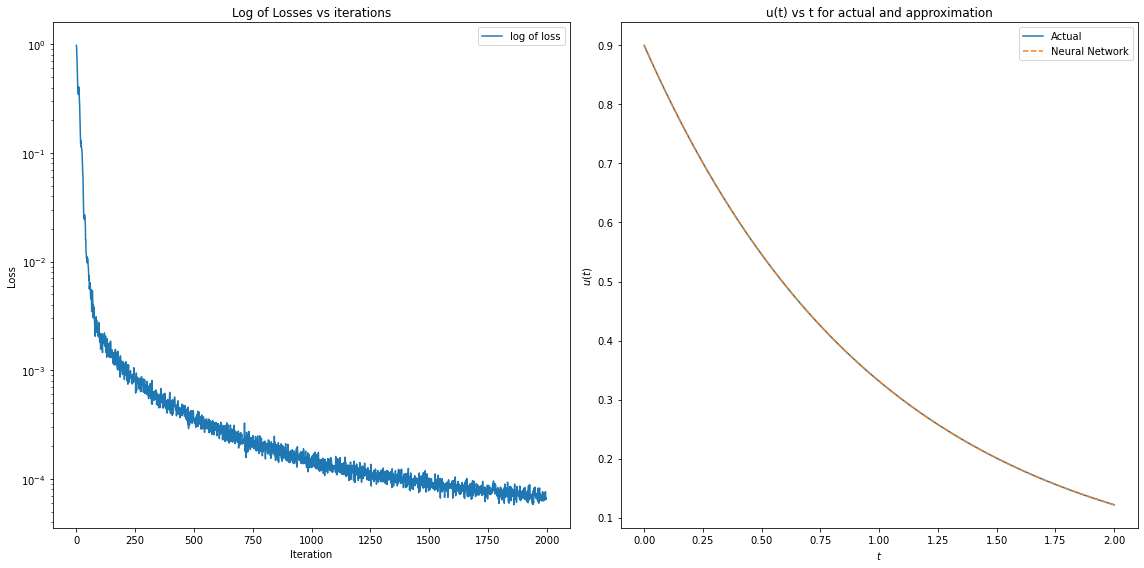

In [13]:
min_x, max_x = 0, 2
A, lambda_val = 0.9, 1
iterations = 2000
loss_term_weights = [1, 0.7, 0.5] # 1, 0.8, 0.2, #1, 0.3, 0.3

# run the trained model with a set number of iterations and for min and max x range
train_losses, trained_model = run_model(iterations=iterations, min_x=min_x, max_x=max_x, A=A, lambda_val=lambda_val, loss_term_weights=loss_term_weights)
plot_loss_and_solution(min_x=min_x, max_x=max_x, A=A, lambda_val=lambda_val, iterations=iterations, trained_model=trained_model, train_losses=train_losses)